In [1]:
# Graphing
import requests
import networkx as nx
import matplotlib.pyplot as plt
import csv
from math import pi, sqrt
from tabulate import tabulate
import numpy as np
import powerlaw

# Co Occurences
import json
from datetime import datetime
from collections import defaultdict

# Graphing of the social network of Game of Thrones

In [2]:
# Functions section

# Function to fetch links from a character's Game of Thrones Fandom Wiki page
def get_character_links(character_name):
    base_url = "https://gameofthrones.fandom.com/api.php"
    params = {
        "action": "parse",
        "page": character_name,
        "prop": "links",
        "format": "json",
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    links = []

    if "parse" in data and "links" in data["parse"]:
        links = [link["*"] for link in data["parse"]["links"] if link["*"] in character_names]

    return links

# Function to find indegree and outdegree of a network
def in_out_degrees(G):
    nodes = [node for node in G.nodes()]
    in_degrees = dict(G.in_degree(nodes))
    out_degrees = dict(G.out_degree(nodes))

    in_degrees = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
    out_degrees = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]

    return in_degrees, out_degrees

In [3]:
# Load the CSV file with the Game of Thrones characters' names
character_names = []

with open("characters_v4.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        character_names.append(row[0])

# Create a directed NetworkX graph
G = nx.DiGraph()

for character_name in character_names:
    G.add_node(character_name)

# Populate the graph with directed edges between characters
for character_name in character_names:
    character_links = get_character_links(character_name)
    for link in character_links:
        G.add_edge(character_name, link)

In [4]:
# Save the graph in a GraphML file
nx.write_graphml(G, "got_network.graphml")

In [3]:

# If you have already saved the graph, you can load it from the file
G = nx.read_graphml("got_network.graphml")

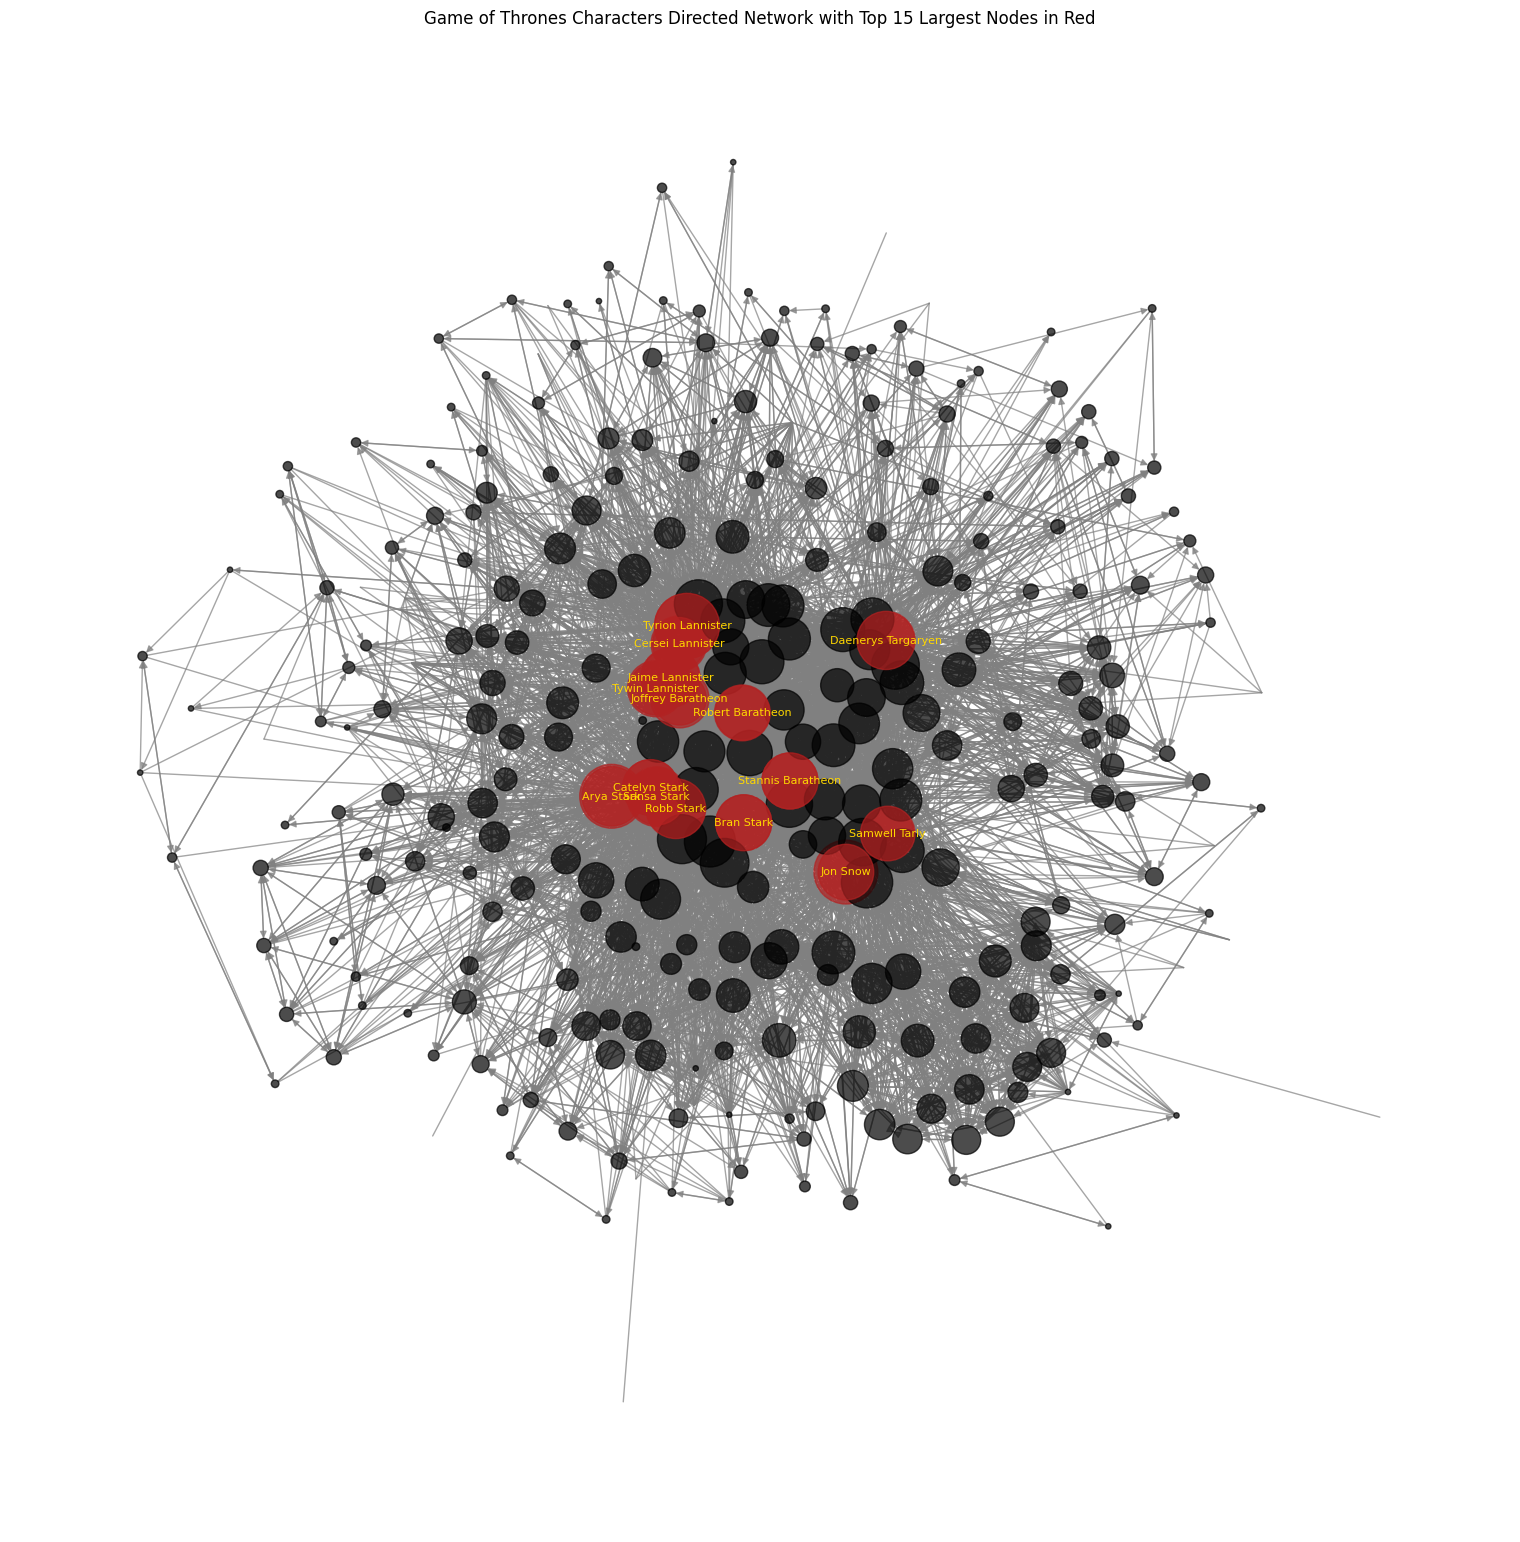

In [4]:
# Calculate in-degrees
in_degrees = G.in_degree()

# Determine the 15 nodes with the highest in-degrees
top_15_nodes = sorted(in_degrees, key=lambda x: x[1], reverse=True)[:15]

# Create a list of labels for the 15 biggest nodes
node_labels = {}
for node, in_degree in top_15_nodes:
    node_labels[node] = node

# Calculate node sizes based on in-degrees
node_sizes = [in_degree * 15 for _, in_degree in in_degrees]

# Use the Kamada-Kawai layout algorithm for node positioning
pos = nx.kamada_kawai_layout(G)

# Increase the figure size for better visualization
plt.figure(figsize=(15, 15))

# Specify a different color for the 15 largest nodes
node_colors = ["firebrick" if node in [node for node, _ in top_15_nodes] else "black" for node in G.nodes()]

# Remove self loops
G.remove_edges_from(nx.selfloop_edges(G))

# Draw nodes with sizes and labels for all nodes except the top 15
nx.draw(G, 
        pos=pos, 
        with_labels=False, 
        node_size=node_sizes, 
        node_color=node_colors, 
        edge_color="grey", 
        font_size=10, 
        alpha=0.7,
        arrows=True
    )

# Draw labels for the 15 largest nodes
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='gold')

# Extract information for the top 15 nodes
top_15_node_list = [node for node, _ in top_15_nodes]
top_node_sizes = [size for node, size in zip(G.nodes(), node_sizes) if node in top_15_node_list]

# Draw the top 15 nodes again to ensure they're on top
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=top_15_node_list, 
                       node_size=top_node_sizes, 
                       node_color="firebrick", 
                       alpha=0.7
                      )

plt.title("Game of Thrones Characters Directed Network with Top 15 Largest Nodes in Red")
plt.show()

Top 5 most connected nodes (characters):

 In Degree                        | Out Degree
----------------------------------+-----------------------------------
 Character        |   In Degree   | Character        |   Out Degree
 ------------------+------------- | ------------------+--------------
 Tyrion Lannister |         145   | Jon Snow         |          125
 Jon Snow         |         140   | Sansa Stark      |           97
 Sansa Stark      |         122   | Tyrion Lannister |           91
 Arya Stark       |         121   | Jaime Lannister  |           91
 Robb Stark       |         117   | Robb Stark       |           90


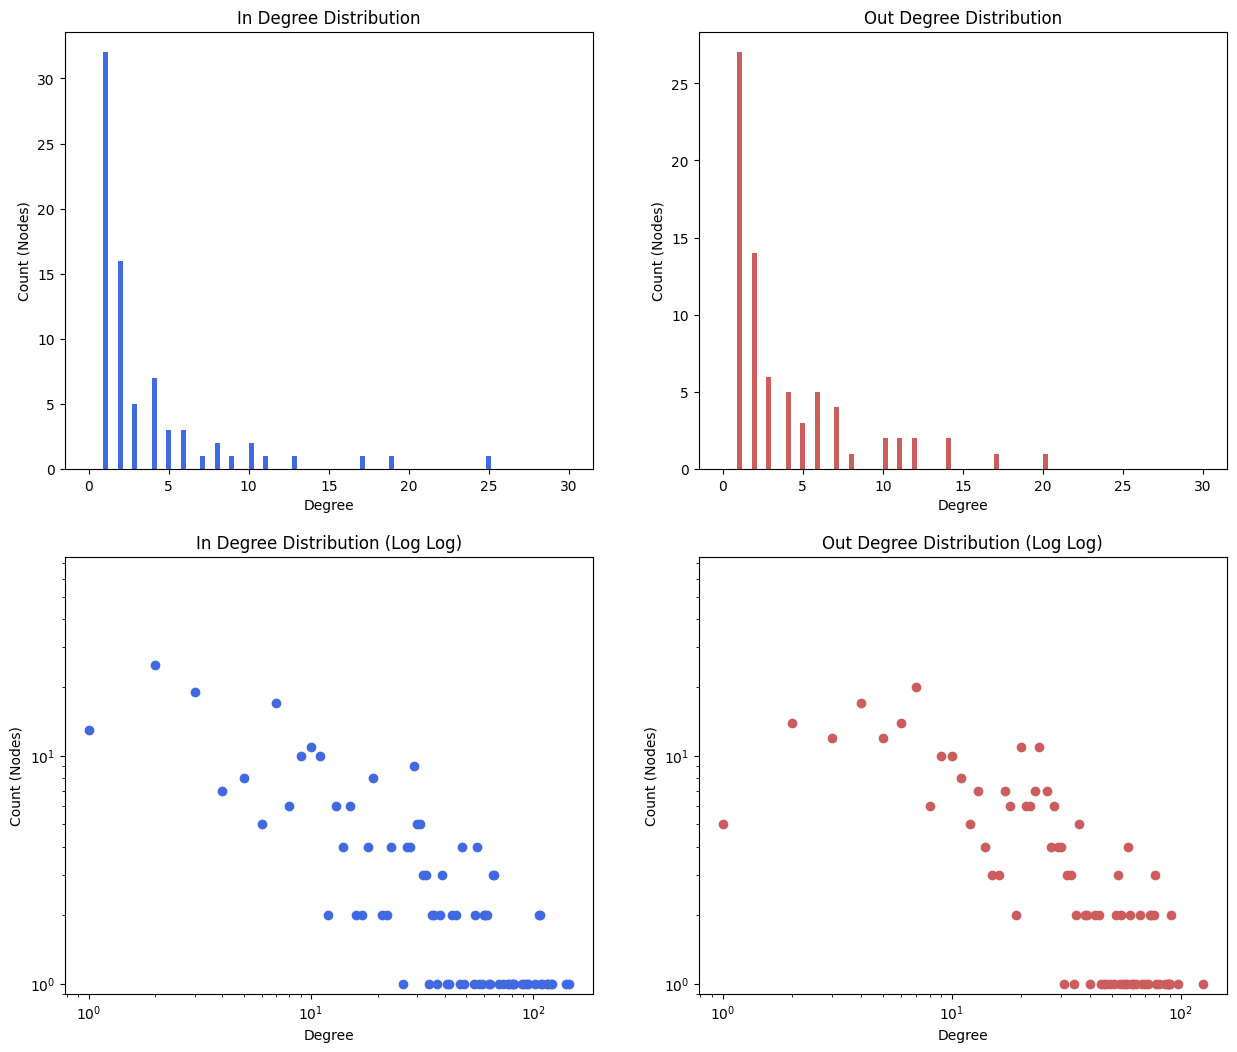

In [12]:
print('Top 5 most connected nodes (characters):\n')
in_degrees, out_degrees = in_out_degrees(G)
in_table = tabulate(in_degrees, headers=['Character', 'In Degree'], tablefmt="presto")
out_table = tabulate(out_degrees, headers=['Character', 'Out Degree'], tablefmt="presto")

table = tabulate([list(item) for item in zip(str(in_table).splitlines(), str(out_table).splitlines())],
                        ["In Degree", "Out Degree"], tablefmt="presto")
print(table)

# In degree distribution
in_degrees = dict(G.in_degree())
in_values = sorted(set(in_degrees.values()))
in_hist = [list(in_degrees.values()).count(x) for x in in_values]

# Out degree distribution
out_degrees = dict(G.out_degree())
out_values = sorted(set(out_degrees.values()))
out_hist = [list(out_degrees.values()).count(x) for x in out_values]

# Bins
bins = np.linspace(0, 30, 100)

plt.figure(figsize=(15, 12.5))
plt.subplot(2, 2, 1)
plt.hist(in_hist, bins=bins, color='royalblue')
plt.title("In Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")

plt.subplot(2, 2, 2)
plt.hist(out_hist, bins=bins, color='indianred')
plt.title("Out Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")

# Log Log plot
plt.subplot(2, 2, 3)
plt.loglog(in_values, in_hist, 'o', color='royalblue')
plt.title("In Degree Distribution (Log Log)")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")
plt.ylim(0.9, 75)

plt.subplot(2, 2, 4)
plt.loglog(out_values, out_hist, 'o', color='indianred')
plt.title("Out Degree Distribution (Log Log)")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")
plt.ylim(0.9, 75)

plt.show()

In [11]:
# Power law fit
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

in_degrees = [in_degree for _, in_degree in in_degrees.items()]
out_degrees = [out_degree for _, out_degree in out_degrees.items()]

in_fit = powerlaw.Fit(in_degrees)
out_fit = powerlaw.Fit(out_degrees)

print("In Degree Power Law Fit")
print("alpha in = ", in_fit.power_law.alpha)
print("alpha out = ", out_fit.power_law.alpha)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
In Degree Power Law Fit
alpha in =  3.744274775510896
alpha out =  2.4640203759503483


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


# Co Occurences within Game of Thrones

In [2]:
# Functions section

character_colors = defaultdict(lambda: '#DBA374')

def time_to_seconds(t):
    time = datetime.strptime(t, '%H:%M:%S').time()
    return time.hour*3600 + time.minute*60 + time.second

def seconds_to_time(s):
    return datetime.utcfromtimestamp(s).strftime('%H:%M:%S')

def top_n_characters(matrix, characters, n=50):
    summed_times = [(idx, sum(row)) for (idx, row) in enumerate(matrix)]
    summed_times = sorted(summed_times, key=lambda x: x[1], reverse=True)
    top_n = summed_times[:n]
    top_n = [(characters[idx], time) for (idx, time) in top_n]
    return top_n

def normalize_matrix(matrix):
    normalized_matrix = []
    for row in matrix:
        total = sum(row)
        if total == 0:
            normalized_matrix.append(row)
            continue
        normalized_row = [val/total for val in row]
        normalized_matrix.append(normalized_row)
    return normalized_matrix

def is_symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i][j] != matrix[j][i]:
                return False
    return True

def matrix_eye(matrix):
    eye = [matrix[i][i] for i in range(len(matrix))]
    return any(eye)

def make_graph(matrix_full, characters):
    matrix_norm = normalize_matrix(matrix_full)
    G = nx.Graph()
    for (idx, row) in enumerate(matrix_full):
        total_time = sum(row)
        G.add_node(characters[idx], total_time=total_time)
    
    for i in range(len(characters)):
        for j in range(len(characters)):
            if i != j:
                time_norm = matrix_norm[i][j]
                if time_norm == 0.0:
                    continue
                G.add_edge(characters[i], characters[j], time_norm=time_norm)
    return G

def make_digraph(matrix_full, characters):
    matrix_norm = normalize_matrix(matrix_full)
    DG = nx.DiGraph()
    for (idx, row) in enumerate(matrix_full):
        total_time = sum(row)
        DG.add_node(characters[idx], total_time=total_time)
    
    for i in range(len(characters)):
        for j in range(len(characters)):
            if i != j:
                time_norm = matrix_norm[i][j]
                if time_norm == 0.0:
                    continue
                DG.add_edge(characters[i], characters[j], interaction_time=time_norm)
    return DG

def area_to_radius(area):
    return  (area / pi)**0.5

def color_nodes(G):
    colors = []
    for node in G.nodes():
        colors.append(character_colors[node])
    return colors

def draw_graph(G):
    node_sizes = nx.get_node_attributes(G, 'total_time').values()
    node_sizes = [v*0.01 for v in node_sizes]
    edges = G.edges()
    widths = [G[u][v]['time_norm'] * 35 for u,v in edges]
    k = 1 / sqrt(len(G.nodes())) * 4
    nx.draw(G,
            pos=nx.spring_layout(G, k=k),
            with_labels=True,
            edge_color='grey',
            node_size=node_sizes,
            node_color=color_nodes(G),
            alpha=.7,
            font_color='black',
            width=widths,
    )

def draw_digraph(G):
    node_sizes = nx.get_node_attributes(G, 'total_time').values()
    node_sizes = [area_to_radius(v) * 10 for v in node_sizes]
    edge_widths = [G[u][v]['interaction_time'] * 8 for u,v in G.edges()]
    k = 1 / sqrt(len(G.nodes())) * 5
    nx.draw(G,
            pos=nx.spring_layout(G, k=k),
            with_labels=True,
            edge_color='grey',
            node_size=node_sizes,
            node_color=color_nodes(G),
            alpha=.7,
            font_color='black',
            width=edge_widths,
    )

In [8]:
episodes_data = json.load(open('data/raw/episodes.json', 'r'))
characters_data = json.load(open('data/raw/characters.json', 'r'))
colors = json.load(open('data/raw/colors.json', 'r'))
colors = colors['houses']


episodes = episodes_data['episodes']
print('Number of episodes:', len(episodes))

characters = set()
characters_by_season = {}

for episode in episodes:
    season = episode['seasonNum']
    scenes = episode['scenes']
    for scene in scenes:
        scene_length = time_to_seconds(scene['sceneEnd']) - time_to_seconds(scene['sceneStart'])
        scene['sceneLength'] = scene_length
        for character in scene['characters']:
            name = character['name']
            characters.add(name)
            if season not in characters_by_season:
                characters_by_season[season] = set()
            characters_by_season[season].add(name)

# Sort characters characters_by_season
characters = sorted(list(characters))
for season in characters_by_season:
    characters_by_season[season] = sorted(list(characters_by_season[season]))

# Create a dict of character name to color
character_colors = defaultdict(lambda: '#DBA374')
for character in characters_data['characters']:
    name = character['characterName']

    if name not in characters:
        continue
    
    if 'houseName' in character:
        if isinstance(character['houseName'], list):
            house = character['houseName'][0]
        else:
            house = character['houseName']

        if house in colors:
            character_colors[name] = colors[house]
        else:
            print("WARNING missing color for house:", house)

Number of episodes: 73
WARNING missing color for house: Arryn
WARNING missing color for house: Umber
WARNING missing color for house: Tarly
